**Importing basic libraries**

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import os
print(os.listdir("../input"))



['Admission_Predict_Ver1.1.csv', 'Admission_Predict.csv']


In [2]:
adm_pred1=pd.read_csv('../input/Admission_Predict.csv',index_col=0)
adm_pred1_1=pd.read_csv('../input/Admission_Predict_Ver1.1.csv',index_col=0)

We shall combine version 1 and 1.1 of admission predict.

In [3]:
data=pd.concat([adm_pred1,adm_pred1_1])
data.sample(5)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
188,335,118,5,4.5,3.5,9.44,1,0.93
268,314,107,3,3.0,3.5,8.17,1,0.73
125,301,106,4,2.5,3.0,8.47,0,0.57
173,322,110,4,4.0,5.0,9.13,1,0.86
210,301,104,3,3.5,4.0,8.12,1,0.68


**Basic EDA**

In [4]:
data.shape

(900, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 1 to 500
Data columns (total 8 columns):
GRE Score            900 non-null int64
TOEFL Score          900 non-null int64
University Rating    900 non-null int64
SOP                  900 non-null float64
LOR                  900 non-null float64
CGPA                 900 non-null float64
Research             900 non-null int64
Chance of Admit      900 non-null float64
dtypes: float64(4), int64(4)
memory usage: 63.3 KB


In [6]:
data.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,900.000000,900.000000,900.000000,900.000000,900.00000,900.000000,900.000000,900.000000
mean,316.621111,107.288889,3.102222,3.385556,3.47000,8.586433,0.554444,0.722900
std,11.369700,6.073968,1.143048,0.997612,0.91319,0.600822,0.497303,0.141722
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.340000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.140000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.570000,1.000000,0.730000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.052500,1.000000,0.822500
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.970000


GRE Scores, TOEFL Scores and CGPA are somewhat normally distributed.

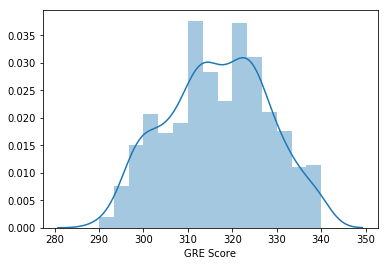

In [7]:
sns.distplot(data['GRE Score'],kde=True)

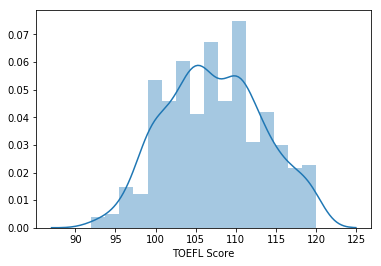

In [8]:
sns.distplot(data['TOEFL Score'],kde=True)

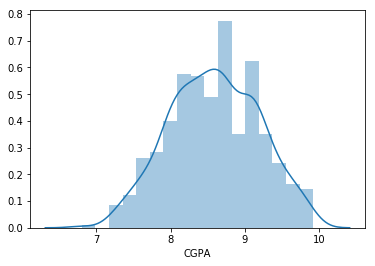

In [9]:
sns.distplot(data['CGPA'],kde=True)

In [10]:
data.rename(columns={'LOR ':'LOR','Chance of Admit ':'CoA'},inplace=True)

Here again, the mediocres prevail !

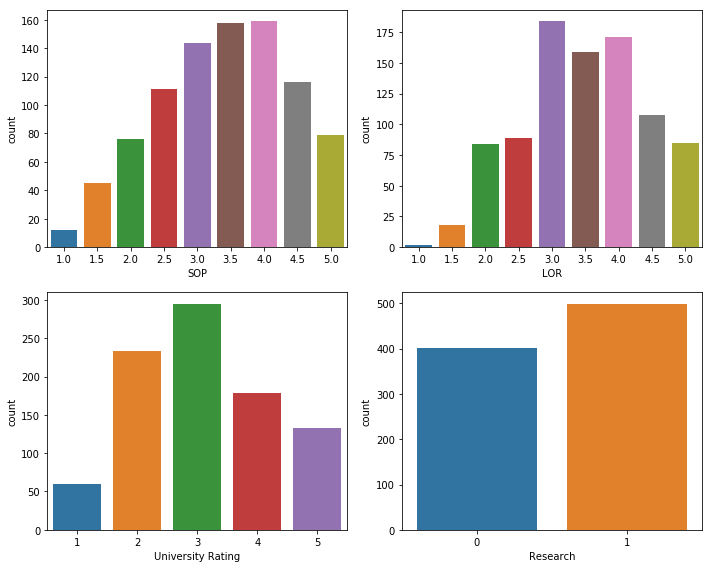

In [11]:
plt.subplots(2,2,figsize=(10,8))
plt.subplot(2,2,1)
sns.countplot(data['SOP'])
plt.subplot(2,2,2)
sns.countplot(data['LOR'])
plt.subplot(2,2,3)
sns.countplot(data['University Rating'])
plt.subplot(2,2,4)
sns.countplot(data['Research'])

plt.tight_layout()

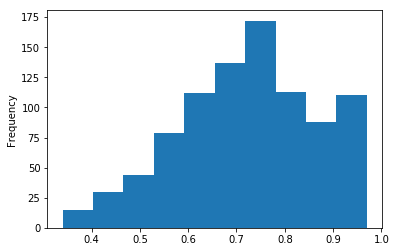

In [12]:
data['CoA'].plot.hist()

Now, let us explore how Chance of Admit depends on various factors.

As expected, Chance of Admit increases as GRE, TOEFL Score and CGPA increases

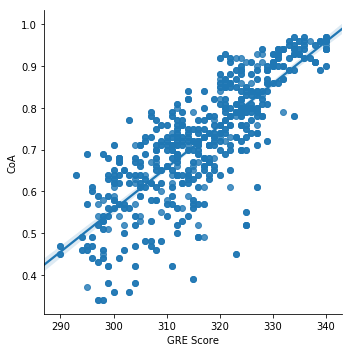

In [13]:

sns.lmplot(x='GRE Score',y='CoA',data=data)


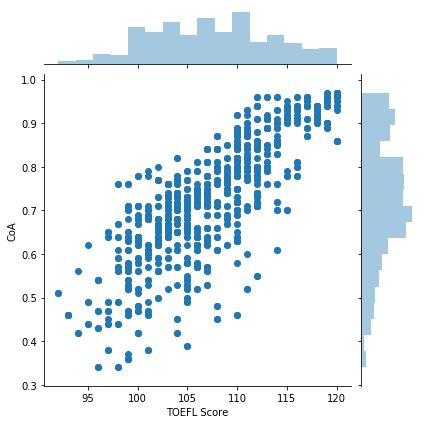

In [14]:
sns.jointplot(x='TOEFL Score',y='CoA',data=data)

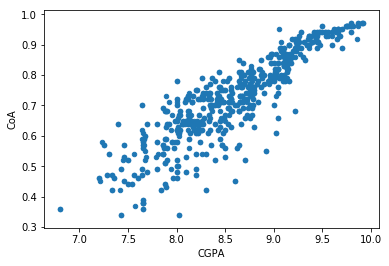

In [15]:
data.plot.scatter(x='CGPA',y='CoA')

On an average, as SOP,LOR, University Rating increases in value, the chance of admit increases aswell. If you practice research aswell then too, chance of admit increases. This matches intuition. 

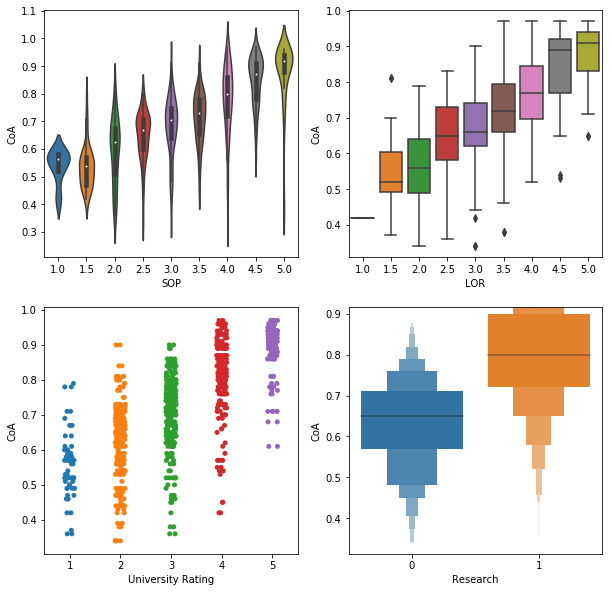

In [16]:
plt.subplots(2,2,figsize=(10,10))
plt.subplot(2,2,1)
sns.violinplot(x='SOP',y='CoA',data=data)
plt.subplot(2,2,2)
sns.boxplot(x='LOR',y='CoA',data=data)
plt.subplot(2,2,3)
sns.stripplot(x='University Rating',y='CoA',data=data)
plt.subplot(2,2,4)
sns.boxenplot(x='Research',y='CoA',data=data)

In [17]:
data.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
CoA                  0
dtype: int64

In [18]:


X=data.drop('CoA',axis=1)
Y=data['CoA']
train_X,val_X,train_y,val_y=train_test_split(X,Y,test_size=0.2,random_state=1)



**Most Basic model : Linear Regression**

In [19]:
lr=LinearRegression()
lr.fit(train_X,train_y)
pred=lr.predict(val_X)
score=mean_squared_error(val_y,pred)
print(score)

0.003575223970565063


**Random Forest Without Optimization**

In [20]:


rfr=RandomForestRegressor(random_state=1)
rfr.fit(train_X,train_y)
pred_rfr=rfr.predict(val_X)
score_rfr=mean_squared_error(pred_rfr,val_y)
print(score_rfr)

0.0017412833333333333


**XBGRegressor Without Optimization**

In [21]:


Xgb=xgb.XGBRegressor(random_state=1)
Xgb.fit(train_X,train_y)
pred_xgb=Xgb.predict(val_X)
score_xgb=mean_squared_error(val_y,pred_xgb)
print(score_xgb)

0.0028544941155075375


We can see that upto now, Random Forest has got the least mse,followed by XGB and then Linear Regression.
Now let us try to fine tune some hyprparameters of Random Forest and XGB.

**Using Hyperopt for Fine tuning with informed method**

GridSearch and Random Search are some other methods to find optimal solution within provided range of parameters. But these two approach the problem in an **uninformed manner**, that is, they don't use the score of previous parameters to search for new set of parameters while on the other hand, Hyperopt follows **informed method**. It uses the score of previous parameters to approach to new set of parameters for hopefully better score. 

In [22]:


seed=2
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    model=RandomForestRegressor(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)
    model.fit(train_X,train_y)
    pred=model.predict(val_X)
    score=mean_squared_error(val_y,pred)
    return score

def optimize(trial):
    params={'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.uniform('max_depth',5,20),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
           'min_samples_split':hp.uniform('min_samples_split',2,6)}
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=500,rstate=np.random.RandomState(seed))
    return best

trial=Trials()
best=optimize(trial)


        
    

100%|██████████| 500/500 [04:00<00:00,  1.62it/s, best loss: 0.0014297633351616798]


In [23]:
print(best)

{'max_depth': 17.93950956784251, 'min_samples_leaf': 1.6038568575218963, 'min_samples_split': 2.622638050847618, 'n_estimators': 120.06608726082656}


From this, we can see how Hyperopt is really working.

In [24]:
for t in trial.trials[:2]:
    print (t)

{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 0.0028856666915888503, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [0], 'min_samples_leaf': [0], 'min_samples_split': [0], 'n_estimators': [0]}, 'vals': {'max_depth': [6.44924027262962], 'min_samples_leaf': [3.2557038491408083], 'min_samples_split': [3.705893814587132], 'n_estimators': [310.68170422696016]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 5, 26, 13, 6, 1, 182000), 'refresh_time': datetime.datetime(2019, 5, 26, 13, 6, 1, 623000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 0.0026257542438432447, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [1], 'min_samples_leaf': [1], 'min_samples_split': [1], 'n_estimators': [1]}, 'vals': {'max_depth': [13.330641077198102], 'min_samples_leaf': [4.1346696482442695], 'min_sample

 tid is the time id.  

In [25]:
TID=[t['tid'] for t in trial.trials]
Loss=[t['result']['loss'] for t in trial.trials]
maxd=[t['misc']['vals']['max_depth'][0] for t in trial.trials]
nest=[t['misc']['vals']['n_estimators'][0] for t in trial.trials]
min_ss=[t['misc']['vals']['min_samples_split'][0] for t in trial.trials]
min_sl=[t['misc']['vals']['min_samples_leaf'][0] for t in trial.trials]

hyperopt_rfr=pd.DataFrame({'tid':TID,'loss':Loss,
                          'max_depth':maxd,'n_estimators':nest,
                          'min_samples_split':min_ss, 'min_samples_leaf':min_sl})



We can see how hyperopt makes the parameters approach some value as tid increases. This is done to minimize the loss.


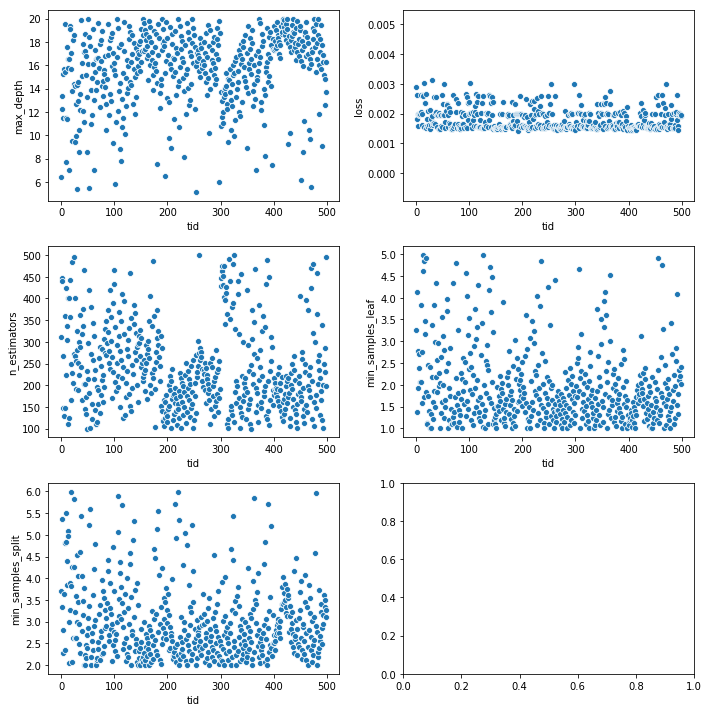

In [26]:
plt.subplots(3,2,figsize=(10,10))
plt.subplot(3,2,1)
sns.scatterplot(x='tid',y='max_depth',data=hyperopt_rfr)
plt.subplot(3,2,2)
sns.scatterplot(x='tid',y='loss',data=hyperopt_rfr)
plt.subplot(3,2,3)
sns.scatterplot(x='tid',y='n_estimators',data=hyperopt_rfr)
plt.subplot(3,2,4)
sns.scatterplot(x='tid',y='min_samples_leaf',data=hyperopt_rfr)
plt.subplot(3,2,5)
sns.scatterplot(x='tid',y='min_samples_split',data=hyperopt_rfr)

plt.tight_layout()

In [27]:

seed=5
def objective2(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    learning=params['learning_rate']
    
    
    model=xgb.XGBRegressor(n_estimators=est,max_depth=md,learning_rate=learning)
    model.fit(train_X,train_y)
    pred=model.predict(val_X)
    score=mean_squared_error(val_y,pred)
    return score

def optimize2(trial):
    params={'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.uniform('max_depth',5,20),
           'learning_rate':hp.uniform('learning_rate',0.01,0.1)}
    best2=fmin(fn=objective2,space=params,algo=tpe.suggest,trials=trial,max_evals=500,rstate=np.random.RandomState(seed))
    return best2

trial2=Trials()
best2=optimize2(trial2)

100%|██████████| 500/500 [02:58<00:00,  2.64it/s, best loss: 0.0008296475369133174]


In [28]:
print(best2)

{'learning_rate': 0.0644621180458839, 'max_depth': 9.712389914609865, 'n_estimators': 427.5377344025042}


In [29]:
TID2=[t['tid'] for t in trial2.trials]
Loss2=[t['result']['loss'] for t in trial2.trials]
maxd2=[t['misc']['vals']['max_depth'][0] for t in trial2.trials]
nest2=[t['misc']['vals']['n_estimators'][0] for t in trial2.trials]
lrt=[t['misc']['vals']['learning_rate'][0] for t in trial2.trials]


hyperopt_xgb=pd.DataFrame({'tid':TID2,'loss':Loss2,
                          'max_depth':maxd2,'n_estimators':nest2,
                          'learning_rate':lrt})

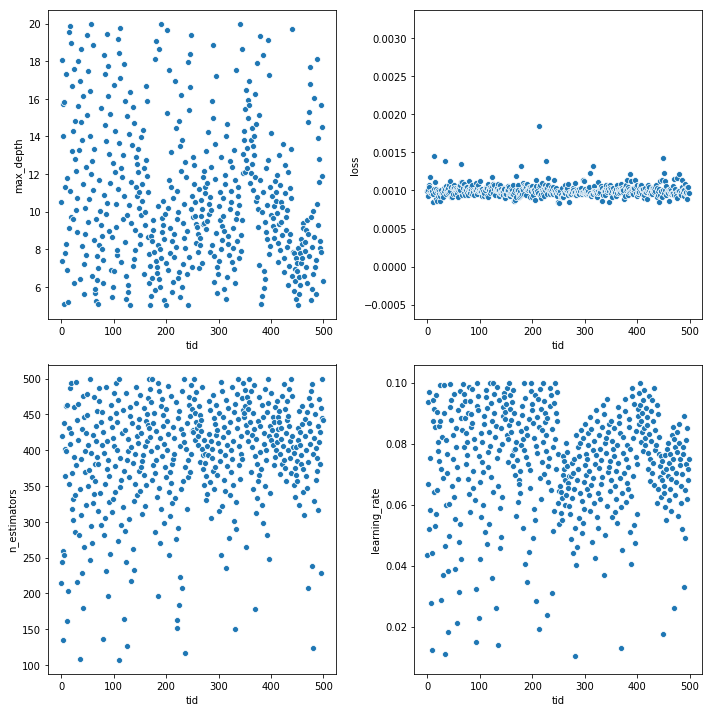

In [30]:
plt.subplots(2,2,figsize=(10,10))
plt.subplot(2,2,1)
sns.scatterplot(x='tid',y='max_depth',data=hyperopt_xgb)
plt.subplot(2,2,2)
sns.scatterplot(x='tid',y='loss',data=hyperopt_xgb)
plt.subplot(2,2,3)
sns.scatterplot(x='tid',y='n_estimators',data=hyperopt_xgb)
plt.subplot(2,2,4)
sns.scatterplot(x='tid',y='learning_rate',data=hyperopt_xgb)


plt.tight_layout()

Finally, after some hyperparameter tuning, we got much lower mean squared error values. Now, XGB has given lower mse than Random Forest. 

In [31]:

rfr_opt=RandomForestRegressor(n_estimators=151,max_depth=17,min_samples_split=2,min_samples_leaf=1)
rfr_opt.fit(train_X,train_y)
pred_rfr_opt=rfr_opt.predict(val_X)
score_rfr_opt=mean_squared_error(val_y,pred_rfr_opt)
print(score_rfr_opt)

xgb_opt=xgb.XGBRegressor(n_estimators=427,max_depth=9,learning_rate=0.06446)
xgb_opt.fit(train_X,train_y)
pred_xgb_opt=xgb_opt.predict(val_X)
score_xgb_opt=mean_squared_error(val_y,pred_xgb_opt)
print(score_xgb_opt)

0.0015327798198185225
0.0008447661181374516
